In [4]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import os
import torch
from occurrence_data import load_filtered_occurrences, get_occurrences, save_filtered_data
from data_download import get_preprocessed_song_ids

In [5]:
occ = load_filtered_occurrences()

In [96]:
from os import walk

def get_preprocessed_song_ids(song_dir_path = '/Volumes/COCO-DATA/songs_npy/'):
    fs = []
    for _, _, fnames in walk(song_dir_path):
        for f in fnames:
            fs.append(int(f.strip('.npy')))
    
    return fs

preprocessed = get_preprocessed_song_ids()

In [24]:
downloaded = occ['gbifID'].to_numpy()

In [98]:
print(len(preprocessed))

240087


In [8]:
import tarfile, json, glob, os, io
from occurrence_data import load_filtered_occurrences

occ = load_filtered_occurrences()  # with gbifID & species
occ['species'] = occ['species'].cat.codes
files = glob.glob('/Volumes/COCO-DATA/songs_npy/*.npy')
files = sorted(files)

for fpath in files[:10]:
    key = os.path.basename(fpath).replace('.npy','')
    species = int(occ.loc[occ['gbifID']==int(key),'species'])
    print(key, species)

2243549891 144
2243549931 143
2243549968 127
2243549978 24
2243549980 7
2243549994 227
2243549997 224
2243550007 34
2243550008 128
2243550010 95


/var/folders/l2/p5w_f2bx6cz7b2p1jb5y5kn00000gn/T/ipykernel_13138/106241149.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  species = int(occ.loc[occ['gbifID']==int(key),'species'])


In [21]:
ids = downloaded[~np.isin(downloaded, preprocessed)]

In [87]:
import random

sizes = np.array([0.1, 0.4, 0.5])
a = np.arange(1700)
# print(np.all(a < 1) and np.sum(a) == 1)
# print(np.round(145.5))
splits = []
for i in range(0, len(a)):
    n = np.ceil(sizes[i] * len[a]) if i == 0 else np.floor(sizes[i] * len[a]) 
    sample = random.sample(a, n)
    splits.append(sample)
    a = np.isin()

17000
68000
85000


In [95]:
print(np.ceil(1))

1.0


In [ ]:
indices = np.arange(240087)
np.random.shuffle(indices)
train, val, test = np.split(indices, [168061, 168061+36013])
print(iter(train))

28203


In [2]:
import torch
import webdataset as wds
from torch.utils.data import DataLoader, random_split
from torch.functional import F

def preprocess(sample):
    spectrogram = torch.tensor(sample[0], dtype=torch.float32)
    label  = torch.tensor(sample[1]['species'], dtype=torch.long)
    return spectrogram, label

def pad_collate(batch):
    specs = []
    labels = []
    for spect, species in batch:
        L = spect.shape[-1]
        if L < 280:
            pad = 280 - L
            spect = F.pad(spect, (0,pad))
        specs.append(spect)
        labels.append(species)
    specs = torch.stack([s[None] for s in specs])  # [B,1,F,T]
    labels = torch.tensor(labels, dtype=torch.long)
    return specs, labels

urls = "/Volumes/COCO-DATA/shards/shard-{000000..000240}.tar"
dataset = (
    wds.WebDataset(urls, shardshuffle=1000)
       .decode()
       .rename(spectrogram='npy', species='json')
       .to_tuple('spectrogram', 'species') 
       .map(preprocess)
)
# train, val, test = random_split(dataset, [0.7, 0.15, 0.15])
loader = DataLoader(dataset, batch_size=128, collate_fn=pad_collate)
print(next(iter(loader))[0].shape)

torch.Size([128, 1, 257, 280])


In [16]:
print(occ.iloc[107810, :])

gbifID                     3129078550
species             Muscicapa striata
decimalLatitude               58.7694
decimalLongitude               23.899
Name: 346558, dtype: object


In [52]:
from sklearn.model_selection import train_test_split
import tarfile, json, glob, os, io

occ = load_filtered_occurrences()  # with gbifID & species
occ['species'] = occ['species'].cat.codes
files = glob.glob('/Volumes/COCO-DATA/songs_npy/*.npy')
files = sorted(files)
print(files[0])
# shard_size = 1000
# train_val, test = train_test_split(occ, test_size=0.2, train_size=0.8)
# train, val = train_test_split(train_val, test_size = 0.25, train_size =0.75)

# for i in range(0, len(files), shard_size):
#     shard_id = i // shard_size
#     with tarfile.open(f'/Volumes/COCO-DATA/shards/shard-{shard_id:06d}.tar', 'w') as tar:
#         for fpath in files[i:i+shard_size]:
#             key = os.path.basename(fpath).replace('.npy','')
#             tar.add(fpath, arcname=f'{key}.npy')
#             species = int(occ.loc[occ['gbifID']==int(key),'species'])
#             info = json.dumps({'__key__': key, 'species': species}).encode('utf-8')
#             tarinfo = tarfile.TarInfo(name=f'{key}.json')
#             tarinfo.size = len(info)
#             tar.addfile(tarinfo, io.BytesIO(info))
        
#         if (i % 100 == 0):
#             print('Processed file [%d]/[%d]\r'%(i, len(files)), end="")


/Volumes/COCO-DATA/songs_npy/2243549891.npy


In [ ]:
from os import path

def preprocess_and_save(occurrences, song_dir_path = '/Volumes/COCO-DATA/songs/', npy_dir_path = '/Volumes/COCO-DATA/songs_npy/'):
    n = 0
    for i, id in enumerate(occurrences['gbifID'].values):
        npy_path = path.join(npy_dir_path, str(id) + '.npy')
        try:
            if not path.isfile(npy_path):
                n += 1
        except:
            continue

        if (i % 100 == 0):
            print('Processed file [%d]/[%d]\r'%(i, occurrences.shape[0]), end="")

    return n

## Signal preprocessing

In [ ]:
n_fft = int(0.0107 * 48000) #  10.7 ms at 48 kHz
hop_length = int(0.008 * 48000) # 0.008 s × 48000 Hz = 384 samples (8 ms)
win_length = 512 # use the full 512‐sample window
DD = librosa.istft(
    D[:, ind_vec],
    n_fft=512,
    hop_length=384,
    win_length=512,
    window="hann"
)
import soundfile as sf

sf.write('stereo_file.wav', DD, sr, subtype='PCM_24')

In [17]:
from uuid import UUID
from pathlib import Path

def is_valid_uuid(val):
    try:
        uuid.UUID(str(val))
        return True
    except ValueError:
        return False
    
def is_int(val):
    try:
        int(val)
        return True
    except ValueError:
        return False

fs = []
for dirpath, dnames, fnames in os.walk("/Volumes/COCO-DATA/songs/"):
    for f in fnames:
        fs.append(int(f))

print(len(fs))

278729


In [13]:
def parse_multimedia(occurences, file_path = '/Volumes/COCO-DATA/0000764-250426092105405/multimedia.txt'):
    multimedia_df = pd.read_csv(file_path, sep='\t')
    multimedia_df = multimedia_df[multimedia_df['gbifID'].isin(occurences['gbifID'])]
    multimedia_df = multimedia_df[multimedia_df['type'] == 'Sound']
    multimedia_df = multimedia_df.reset_index(drop=True)
    return multimedia_df

In [14]:
m2 = parse_multimedia(occurrences)

In [11]:
import requests
from pydub import AudioSegment
import io 

url = 'https://xeno-canto.org/sounds/uploaded/BZVYBRUAAE/XC815942-230526_04_Marsh-Warbler_B%C3%B6hlen%2C-Leipzig%2C-Sachsen%2C-Germany_25-May-2023.wav'
res = requests.get(url, timeout=10)
raw = io.BytesIO(res.content)
id = 123
path = f"/Volumes/COCO-DATA/{id}.mp3"
            
audio = AudioSegment.from_file(raw, format='wav')
audio.export(path, format='mp3')

<_io.BufferedRandom name='/Volumes/COCO-DATA/123.mp3'>

In [ ]:
def download_songs(multimedia_df):
    for i, (id, url, format) in enumerate(zip(multimedia_df['gbifID'], multimedia_df['identifier'], multimedia_df['format'])):
        path = f"/Volumes/COCO-DATA/songs/{id}"
        try:
            if not os.path.isfile(path):
                res = requests.get(url, timeout=10)

                if format == 'audio/vnd.wave':
                    raw = io.BytesIO(res.content)     
                    audio = AudioSegment.from_file(raw, format='wav')
                    audio.export(path, format='mp3')
                else:
                    with open(path, 'wb+') as f:
                        f.write(bytes(res.content))
        except:
            continue

        if (i % 100 == 0):
            print('Downloaded file [%d]/[%d]\r'%(i, multimedia_df.shape[0]), end="")

28499


In [70]:
from occurrence_data import parse_multimedia

print(parse_multimedia(occurrences))

            gbifID   type      format  \
0       2243564691  Sound  audio/mpeg   
1       2243564866  Sound  audio/mpeg   
2       2243565718  Sound  audio/mpeg   
3       2243564841  Sound  audio/mpeg   
4       4173214168  Sound  audio/mpeg   
...            ...    ...         ...   
212536  2243655035  Sound  audio/mpeg   
212537  2243653834  Sound  audio/mpeg   
212538  2243654688  Sound  audio/mpeg   
212539  2243655303  Sound  audio/mpeg   
212540  2243656839  Sound  audio/mpeg   

                                               identifier  references  title  \
0       https://xeno-canto.org/sounds/uploaded/ECOQJFB...         NaN    NaN   
1       https://xeno-canto.org/sounds/uploaded/BTOFEKX...         NaN    NaN   
2       https://xeno-canto.org/sounds/uploaded/BTOFEKX...         NaN    NaN   
3       https://xeno-canto.org/sounds/uploaded/BTOFEKX...         NaN    NaN   
4       https://xeno-canto.org/sounds/uploaded/OSFROUW...         NaN    NaN   
...                        

In [29]:
from data_preprocess import audio_preprocessing_pipeline
s = audio_preprocessing_pipeline('/Users/okkokuisma/Downloads/XC815832-Bruantjaune_StMichelDesLoups_260523_09h02.wav')

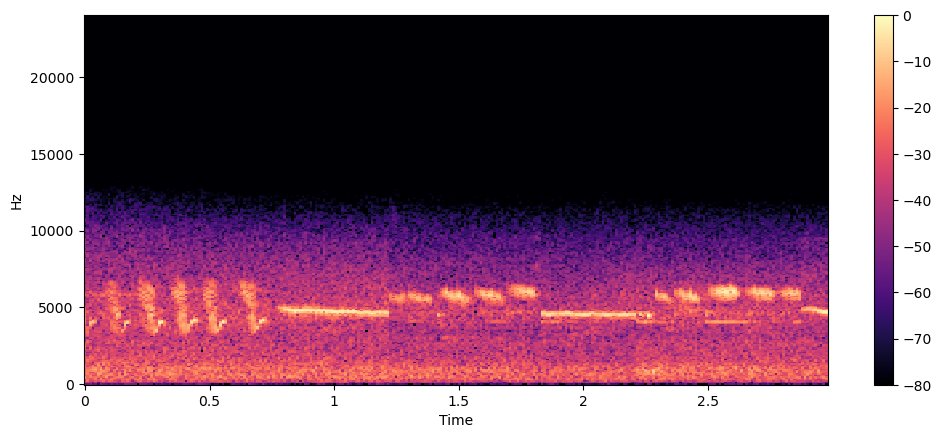

In [30]:
S_db = librosa.amplitude_to_db(np.abs(s), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db[:, :500], x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()

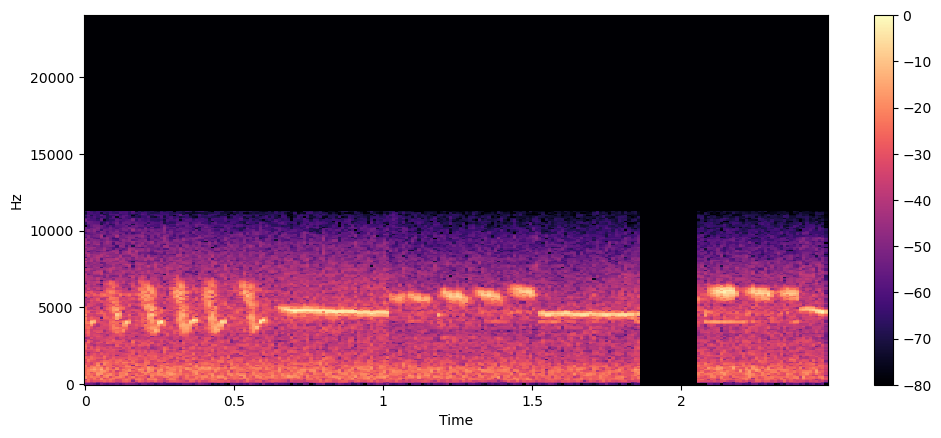

In [41]:
from data_preprocess import augment_song
masked = augment_song(s)
S_db = librosa.amplitude_to_db(masked, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db[:, :500], x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()